# 주소데이터 기반 데이터셋 전처리
- 도로명 주소 기반 위경도 처리

In [83]:
import pandas as pd
import requests, json, pprint
from tqdm import tqdm
from geopy.geocoders import Nominatim

geo_local = Nominatim(user_agent='South Korea')

data = pd.read_csv("./company_info.csv", encoding='utf-8')
data.head()

,Unnamed: 0,name,address
0,0,삼성전자,경기도 수원시 영통구 삼성로 129
1,1,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동)
2,2,SK하이닉스,경기도 이천시 부발읍 경충대로 2091 (아미리)
3,4,NAVER,경기도 성남시 분당구 불정로 6
4,5,삼성바이오로직스,인천광역시 연수구 송도바이오대로 300


In [76]:
data_sort = data[data['address'].str.contains("서울")]
data_sort = data_sort[['name', 'address']].reset_index(drop=True)

# 'lat'과 'lon' 열 신규생성
data_sort['lat'] = None
data_sort['lon'] = None

data_sort.head()

,name,address,lat,lon
0,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동),None,None
1,LG화학,서울특별시 영등포구 여의대로 128,None,None
2,현대차,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),None,None
3,기아,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),None,None
4,KB금융,서울특별시 영등포구 국제금융로8길,None,None


Location(국제금융로8길, 여의동, 영등포구, 서울특별시, 07332, 대한민국, (37.51941825, 126.92790455, 0.0))

In [85]:
# 카카오API를 사용하여 좌표->주소 변환
def get_location_kakao(address_data):
  url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address_data
  headers = {"Authorization": "KakaoAK 20953ebae869efd8abdc3657eba800b6"}
  api_json = json.loads(str(requests.get(url,headers=headers).text))
  address = api_json['documents'][0]['address']
  crd = f"{str(address['y'])}, {str(address['x'])}"
  
  return address, crd

def get_location_nominatim(address_data):
  geo = geo_local.geocode(address_data)
  crd = f"{str(geo.latitude)}, {str(geo.longitude)}"
  
  return crd

for idx, i in tqdm(enumerate(range(len(data_sort)))):
  try:
    _, latlon = get_location_kakao(data_sort['address'][i])
    lat, lon = latlon.split(",")
  
  except Exception as e:  # 예외 발생 시 다른 패키지 사용
    try:
      print(f"can't find in kakaoAPI : {data_sort['address'][i]}, try in another package")
      latlon = get_location_nominatim(data_sort['address'][i])
    
    except:
      print(f"SKIP : can't find : {data_sort['address'][i]}")
      lat, lon = None, None  # 좌표를 None으로 설정
    
  # 좌표 값 유효성 확인 후 데이터 저장
  if lat is not None and lon is not None:
      data_sort.at[i, 'lat'] = lat
      data_sort.at[i, 'lon'] = lon

4it [00:00, 16.07it/s]

can't find in kakaoAPI : 서울특별시 영등포구 국제금융로8길 , try in another package


67it [00:05, 12.44it/s]


In [87]:
data_sort.to_csv("./conpany_info_lonlat_add.csv")

# 데이터 별 구역 확인
- 100대 기업의 주소를 기반으로, 회사가 밀집되어있는 구역 5개 선정
- 해당 구역 기반으로 진행예정

In [88]:
display(data_sort)

,name,address,lat,lon
0,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동),37.5251913154781,126.929112756574
1,LG화학,서울특별시 영등포구 여의대로 128,37.5279271045092,126.929241174348
2,현대차,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),37.4643623227152,127.042663599215
3,기아,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),37.4643623227152,127.042663599215
4,KB금융,서울특별시 영등포구 국제금융로8길,37.4643623227152,127.042663599215
...,...,...,...,...
62,아모레G,서울특별시 용산구 한강대로 100 아모레퍼시픽,37.5287911785354,126.968673565462
63,NH투자증권,서울특별시 영등포구 여의대로 108 파크원 NH금융타워(타워2),37.5251913154781,126.929112756574
64,GS건설,서울특별시 종로구 종로 33 그랑서울,37.5709617749066,126.981437983842
65,KCC,서울특별시 서초구 사평대로 344,37.5029945221484,127.020802535605


# 회사 - 아파트 간 거리 탐색

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import platform


data = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/conpany_info_seoulonly_lonlat_add.csv")

In [111]:
data['spot'] = data['address'].apply(lambda x: x.strip().split(" ")[1])

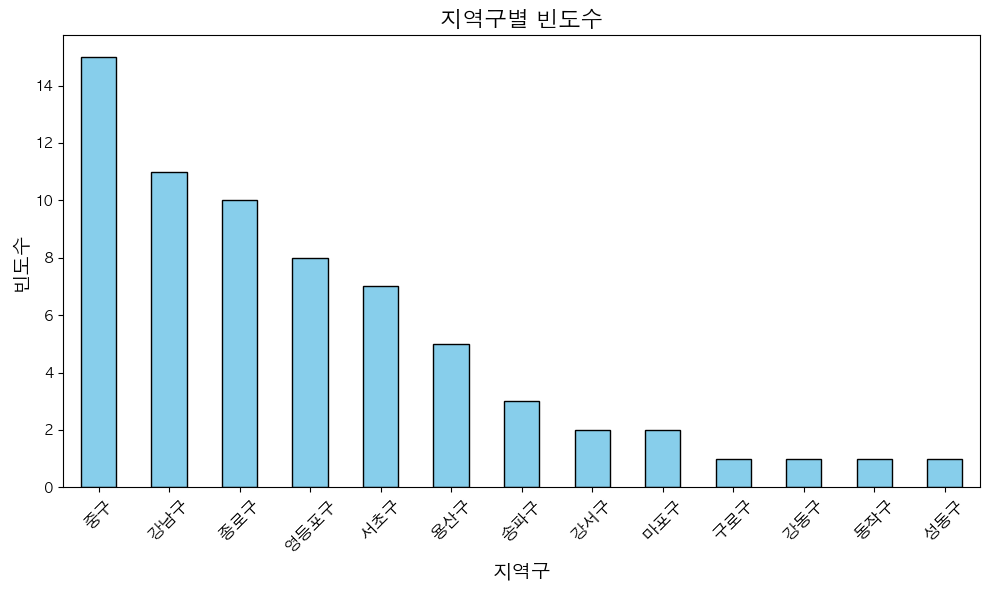

In [112]:
# Font setting
platform.system() == "Darwin"
rc('font', family='AppleGothic')  # macOS: 애플고딕

zone_counts = data['spot'].value_counts()

# 시각화
plt.figure(figsize=(10, 6))
zone_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('지역구별 빈도수', fontsize=16)
plt.xlabel('지역구', fontsize=14)
plt.ylabel('빈도수', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

In [113]:
data[data['spot'] == '영등포구'].reset_index(drop=True)

,Unnamed: 0,name,address,lat,lon,spot
0,0,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동),37.525191,126.929113,영등포구
1,1,LG화학,서울특별시 영등포구 여의대로 128,37.527927,126.929241,영등포구
2,4,KB금융,서울특별시 영등포구 국제금융로8길 2,37.521949,126.930145,영등포구
3,6,LG전자,서울특별시 영등포구 여의대로 128,37.527927,126.929241,영등포구
4,15,LG,서울특별시 영등포구 여의대로 128,37.527927,126.929241,영등포구
5,32,LG디스플레이,서울특별시 영등포구 여의대로 128,37.527927,126.929241,영등포구
6,50,한국금융지주,서울특별시 영등포구 의사당대로 88 한국투자증권빌딩,37.522085,126.922273,영등포구
7,63,NH투자증권,서울특별시 영등포구 여의대로 108 파크원 NH금융타워(타워2),37.525191,126.929113,영등포구


In [114]:
company_spot = data.groupby(by='spot').size().sort_values(ascending=False)
top_5 = company_spot.index.tolist()[0:5]

In [120]:
import folium

map_folium = folium.Map(location=[37.564963866666666, 126.98638033333333], zoom_start=5)
mean_lat_lon_list = []

for idx, i in enumerate(top_5):
    selected = data[data['spot'] == i].reset_index(drop=True)

    for k in range(len(selected)):
        popup = folium.Popup(f"{i} {selected.loc[k]['name']}", max_width=200)
        folium.Marker(location=[selected.loc[k]['lat'],selected.loc[k]['lon']], popup=popup).add_to(map_folium)   

    popup = folium.Popup(f"{i} 중간지점", max_width=200)
    folium.CircleMarker(location=[selected['lat'].mean(), selected['lon'].mean()], popup=popup,
                        radius=10, color='red', fill_color='#EC4074').add_to(map_folium) 
    
    mean_lat_lon_list.append([i, selected['lat'].mean(), selected['lon'].mean()])


In [121]:
map_folium

# 중간지점 데이터 활용 직선거리 체크

In [ ]:
# 각 위치별로 위치하는 회사의 위경도 데이터를 활용하여 중간지점
mean_lat_lon_list

[['중구', 37.56496378420572, 126.98638035749214],
 ['강남구', 37.502597821500075, 127.03775216369364],
 ['종로구', 37.57334034521065, 126.98365886796088],
 ['영등포구', 37.52576565325149, 126.92845099895187],
 ['서초구', 37.483616105357044, 127.03267809993557]]

In [134]:
price_origin = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/apt_price.csv")

In [222]:
price_list = price_origin.copy()
price_list = price_list[['시군구','번지','단지명','도로명','계약년월','계약일','거래금액(만원)']]

In [240]:
selected_list = price_list[price_list['시군구'].str.contains('분당')]
selected_list.loc[:,'거래금액(만원)'] = selected_list['거래금액(만원)'].str.replace(',', '').astype(int)
top5_selected_bundang =  selected_list[selected_list['계약년월']==202411].sort_values(by='거래금액(만원)', ascending=False).reset_index(drop=True)
top5_selected_bundang = top5_selected_bundang[0:5]

# top5_selected_bundang['시군구'] = top5_selected_bundang['시군구'].str.replace(r'\s+\S*동$', '', regex=True)

top5_selected_bundang['위도'] = ""
top5_selected_bundang['경도'] = ""

In [241]:
top5_selected_bundang

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도
0,경기도 성남시 분당구 수내동,34,양지마을(금호1),수내로 74,202411,1,238000,,
1,경기도 성남시 분당구 백현동,554,백현마을5단지(주공),판교역로 102,202411,1,180000,,
2,경기도 성남시 분당구 백현동,608,THESHARP판교퍼스트파크,판교백현로 38,202411,4,170000,,
3,경기도 성남시 분당구 이매동,100,이매촌(삼성),양현로 192,202411,8,150000,,
4,경기도 성남시 분당구 이매동,142,아름마을(선경),이매로 11,202411,8,148000,,


In [242]:
selected_list = price_list[price_list['시군구'].str.contains('일산')]
selected_list.loc[:,'거래금액(만원)'] = selected_list['거래금액(만원)'].str.replace(',', '').astype(int)
top5_selected_ilsan = selected_list[selected_list['계약년월']==202411].sort_values(by='거래금액(만원)', ascending=False).reset_index(drop=True)
top5_selected_ilsan = top5_selected_ilsan[0:5]

# top5_selected_ilsan['시군구'] = top5_selected_ilsan['시군구'].str.replace(r'\s+\S*동$', '', regex=True)

top5_selected_ilsan['위도'] = ""
top5_selected_ilsan['경도'] = ""

In [243]:
top5_selected_ilsan

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도
0,경기도 고양시 일산동구 백석동,1237,일산요진와이시티,강송로 33,202411,13,160000,,
1,경기도 고양시 일산동구 식사동,1498,위시티일산자이2단지,위시티4로 46,202411,2,110000,,
2,경기도 고양시 일산동구 식사동,1565,위시티블루밍5단지,위시티1로 7,202411,2,80000,,
3,경기도 고양시 일산동구 식사동,621-17,일산자이더헤리티지,위시티3로 111,202411,4,73000,,
4,경기도 고양시 일산동구 식사동,1510,위시티블루밍3단지,위시티4로 79,202411,1,69500,,


In [227]:
from geopy.geocoders import Nominatim

# Nominatim으로 좌표 검색 함수
def get_location_nominatim(address_data):
    geolocator = Nominatim(user_agent="chaos")
    location = geolocator.geocode(address_data)
    if location:
        return location.latitude, location.longitude  # 위도, 경도 반환
    return None, None

In [228]:
for i in range(0,5):
    address = f"{top5_selected_bundang['시군구'][i]} {top5_selected_bundang['도로명'][i]}"
    lat, lon = get_location_nominatim(address)
    
    top5_selected_bundang.loc[i,'위도']= lat
    top5_selected_bundang.loc[i,'경도']= lon
    
    if lat is None or lon is None:
        print(f"Failed : {address}")
    
    else:
        print(f"{address} Done.")

경기도 성남시 분당구 수내로 74 Done.
경기도 성남시 분당구 판교역로 102 Done.
경기도 성남시 분당구 판교백현로 38 Done.
경기도 성남시 분당구 양현로 192 Done.
경기도 성남시 분당구 이매로 11 Done.


In [229]:
top5_selected_bundang.head(5)

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도
0,경기도 성남시 분당구,34,양지마을(금호1),수내로 74,202411,1,238000,37.3701,127.127852
1,경기도 성남시 분당구,554,백현마을5단지(주공),판교역로 102,202411,1,180000,37.396969,127.109683
2,경기도 성남시 분당구,608,THESHARP판교퍼스트파크,판교백현로 38,202411,4,170000,37.382378,127.098506
3,경기도 성남시 분당구,100,이매촌(삼성),양현로 192,202411,8,150000,37.416826,127.124412
4,경기도 성남시 분당구,142,아름마을(선경),이매로 11,202411,8,148000,37.391624,127.133011


In [238]:
for i in range(0,5):
    address = f"{top5_selected_ilsan['시군구'][i]} {top5_selected_ilsan['도로명'][i]}"
    lat, lon = get_location_nominatim(address)
    
    top5_selected_ilsan.loc[i,'위도']= lat
    top5_selected_ilsan.loc[i,'경도']= lon
    
    if lat is None or lon is None:
        print(f"Failed : {address}")
    
    else:
        print(f"{address} Done.")

경기도 고양시 일산동구 강송로 33 Done.
경기도 고양시 일산동구 위시티4로 46 Done.
경기도 고양시 일산동구 위시티1로 7 Done.
경기도 고양시 일산동구 위시티3로 111 Done.
경기도 고양시 일산동구 위시티4로 79 Done.


In [239]:
top5_selected_ilsan

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도
0,경기도 고양시 일산동구,1237,일산요진와이시티,강송로 33,202411,13,160000,37.642013,126.792441
1,경기도 고양시 일산동구,1498,위시티일산자이2단지,위시티4로 46,202411,2,110000,37.681765,126.812352
2,경기도 고양시 일산동구,1565,위시티블루밍5단지,위시티1로 7,202411,2,80000,37.674994,126.809043
3,경기도 고양시 일산동구,621-17,일산자이더헤리티지,위시티3로 111,202411,4,73000,37.67593,126.814076
4,경기도 고양시 일산동구,1510,위시티블루밍3단지,위시티4로 79,202411,1,69500,37.681765,126.812352


In [126]:
selected_df = pd.DataFrame(mean_lat_lon_list)
selected_df.columns = [['지역', 'lat', 'lon']]

display(selected_df)

,지역,lat,lon
0,중구,37.564964,126.986380
1,강남구,37.502598,127.037752
2,종로구,37.573340,126.983659
3,영등포구,37.525766,126.928451
4,서초구,37.483616,127.032678
